In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from tqdm import tqdm

In [2]:
top_player_ids = {
    292: 'Lionel Messi',
    129: 'Cristiano Ronaldo',
    43: 'Xavi',
    243: 'Iniesta',
    887: 'Neymar',
    506: 'Luka Modric',
    1059: 'Antoine Griezmann',
    397: 'Karim Benzema',
    523: 'Luis Suárez',
    #339: 'Mesut Özil',
    #551: 'Di María',
    #1189: 'Iago Aspas'
}

# Loading VAEP and Probability data

In [3]:
df = pd.read_csv('data/data_for_elo.csv')
df.date = pd.to_datetime(df.date)
df.sample(6)

,gameId,date,playerId,period,second,type,isSuccess,elo_vaep,prob
1021313,1377,2013-03-30,255,1,95,Pass,False,0.00273,0.925
913037,1233,2013-02-17,856,1,1378,Pass,True,-0.01924,0.855
2528990,3356,2018-04-18,1685,1,2199,Pass,True,0.05625,0.205
1490753,2007,2014-10-19,274,2,2773,Pass,True,-0.03119,0.965
2773844,3674,2019-03-02,1269,2,1003,Pass,True,0.00444,0.895
630660,858,2011-10-30,259,2,1976,Pass,False,0.16143,0.575


# Calculating ELO per action

In [4]:
def calculate_elo(df, action_type):
    df_actions = df[df.type == action_type].copy()
    for player_id in tqdm(df_actions.playerId.unique()):
        df_player_actions = df_actions[df_actions.playerId == player_id]

        player_elo_adj = 0
        player_elo_adj_series = []
        for i, action in df_player_actions.iterrows():
            player_elo_adj = player_elo_adj + (1 + 5/(i+1)) * max(action.elo_vaep, 0) * (action.isSuccess - min(max(action.prob + 0.05 * player_elo_adj, 0), 1))
            player_elo_adj_series.append(player_elo_adj)
        
        df_actions.loc[df_actions.playerId == player_id, action_type + '_elo_adj'] = player_elo_adj_series

    return df_actions

In [5]:
df_pass = calculate_elo(df, 'Pass')
df_shot = calculate_elo(df, 'Shot')
df_cross = calculate_elo(df, 'Cross')
df_dribble = calculate_elo(df, 'Dribble')

100%|██████████| 1768/1768 [00:15<00:00, 113.49it/s]


# Grouping ELO per match

In [6]:
df_pass = df_pass.groupby(['playerId', 'date'])[['Pass_elo_adj']].max().reset_index()
df_shot = df_shot.groupby(['playerId', 'date'])[['Shot_elo_adj']].max().reset_index()
df_cross = df_cross.groupby(['playerId', 'date'])[['Cross_elo_adj']].max().reset_index()
df_dribble = df_dribble.groupby(['playerId', 'date'])[['Dribble_elo_adj']].max().reset_index()

# Combine all ELOs in one dataframe

In [7]:
df = df_pass.merge(
    df_shot, on=['playerId', 'date']).merge(
    df_cross, on=['playerId', 'date']).merge(
    df_dribble, on=['playerId', 'date'])

In [8]:
df['all_actions_elo_adj'] = df[['Shot_elo_adj', 'Pass_elo_adj', 'Cross_elo_adj', 'Dribble_elo_adj']].sum(axis=1)

In [9]:
df.to_csv('data/elo_results.csv', index=False)

# Generate visualization for the top players

In [10]:
def plot_elo(df, elo_type, player_ids, names=False):
    for i, player_id in enumerate(player_ids):
        df_player_elo = df[df.playerId == player_id]

        plt.plot(df_player_elo.date, df_player_elo[elo_type].rolling(10, min_periods=1).mean(), lw=3, color=f'black', alpha=1.0);
        plt.plot(df_player_elo.date, df_player_elo[elo_type].rolling(10, min_periods=1).mean(), lw=2, color=f'C{i}', alpha=1.0);

        if names:
            series = df_player_elo.set_index('date')[elo_type].rolling(10, min_periods=1).mean()
            plt.text(series.idxmax(), series.max(), top_player_ids[player_id].split(' ')[-1], color=f'C{i}', fontsize='large', 
                weight="bold", ha='center', path_effects=[pe.withStroke(linewidth=2, foreground="black")])
            
    plt.grid(True, alpha=0.5, linestyle=':')

In [11]:
def plot_all_elo_variables(df, player_ids):
    plt.subplot(311)
    plot_elo(df, 'all_actions_elo_adj', player_ids, names=True)
    plt.ylabel('Sum of\nComponents', fontsize='large')

    plt.subplot(613)
    plot_elo(df, 'Shot_elo_adj', player_ids)
    plt.ylabel('Shot', fontsize='large')
    plt.yticks([0, 2, 4, 6, 8])
    plt.subplot(614)
    plot_elo(df, 'Pass_elo_adj', player_ids)
    plt.ylabel('Pass', fontsize='large')
    plt.subplot(615)
    plot_elo(df, 'Cross_elo_adj', player_ids)
    plt.ylabel('Cross', fontsize='large')
    plt.subplot(616)
    plot_elo(df, 'Dribble_elo_adj', player_ids)
    plt.ylabel('Dribble', fontsize='large')
    plt.subplots_adjust(hspace=.0)

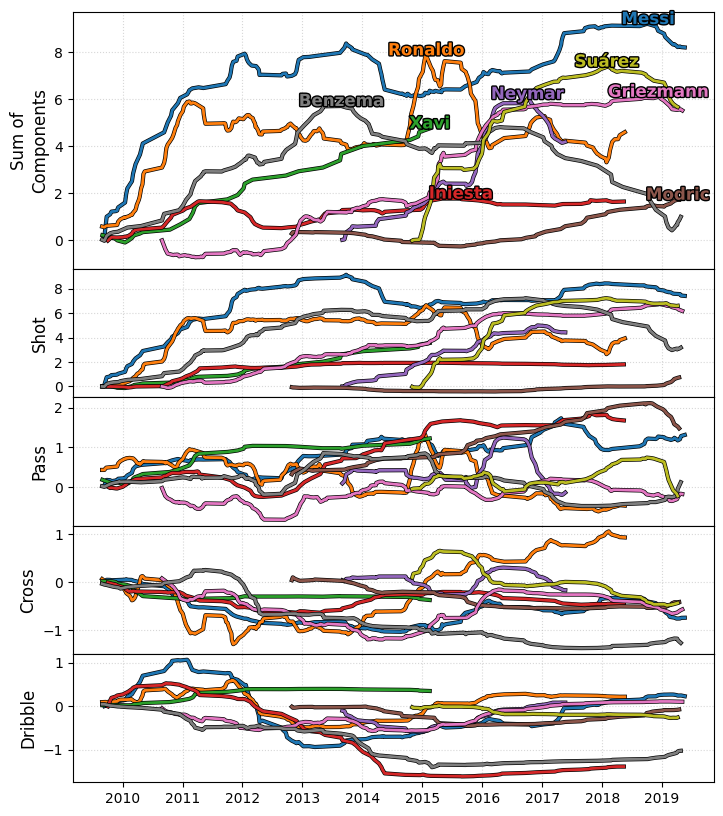

In [13]:
plt.rcParams['figure.figsize'] = (8.27,10)
plot_all_elo_variables(df, top_player_ids.keys())
plt.savefig('fig/abstract_fig.png', dpi=400, bbox_inches='tight')